# Surrogate data generation

The scripts below will use Python and some libraries to generate surrogate data.

In [10]:
# imports
import os
import numpy as np
import wave as wav
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.signal import butter, lfilter
import pandas as pd
from scipy.stats import linregress
from scipy.fftpack import fft, ifft

# Ensure python runs in the same directory as the Jupyter notebook
notebook_dir = "D:/Documents/Actual Documents/004 PhysUBB/14 Master Sem 6/04 Digital Signal Processing/Presentation/JupyterNotebook"
os.chdir(notebook_dir)
#originalFileName = "Original-MHigh-OneBar.wav"
originalFileName = "Original-sea-level.csv"
originalDataSetName = originalFileName.split("-", 1)[1]

## Let's import some data!
For the first example, the sample data we will plot is a .wav file representing a 1-bar loop of a house song named 'Feels like yesterday' by M-High.

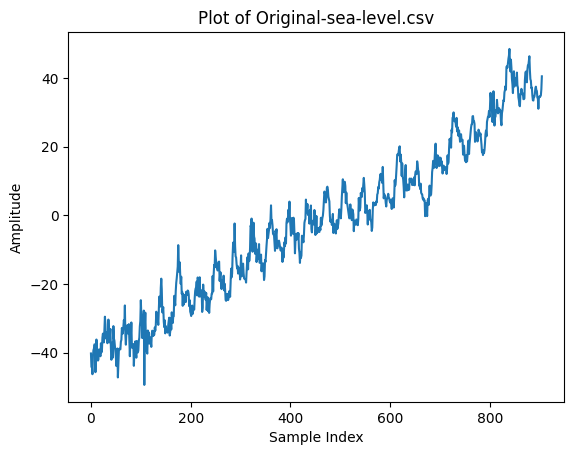

In [11]:
try:
    if originalDataSetName.endswith(".wav"):  
        sr, originalData = wavfile.read(notebook_dir + "/" + f"Original-{originalDataSetName}")
    elif originalDataSetName.endswith(".csv"):
        df = pd.read_csv(notebook_dir + "/" + f"Original-{originalDataSetName}")
        originalData = df['sea_level'].values
        sr = 1
    else:
        print("File type not supported.")
        raise AttributeError(originalDataSetName)
except FileNotFoundError:
    print("The file was not found.")
    raise
except wav.Error as e:
    print(f"An error occurred while reading the wave file: {e}")
    raise

plt.plot(originalData)
plt.title(f'Plot of Original-{originalDataSetName}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

## For this data, let's define some functions
1. One function for plotting the Amplitude distribution
2. Another one for the Power Spectrum

Then let's plot these graphs for the original data!

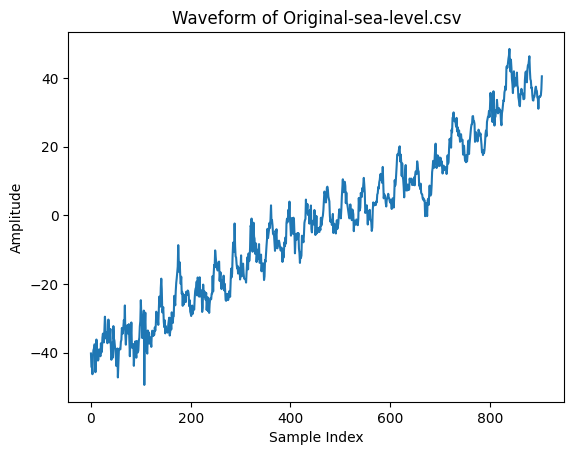

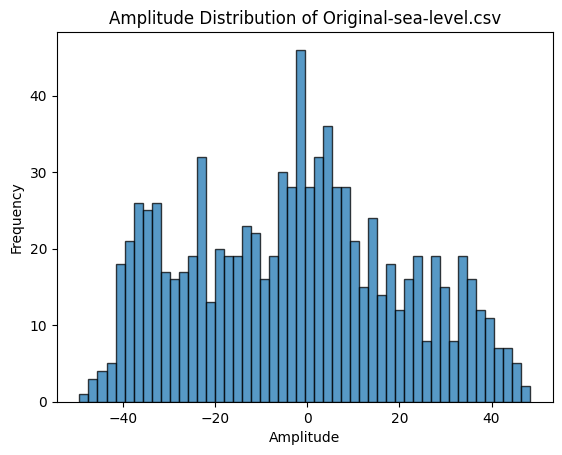

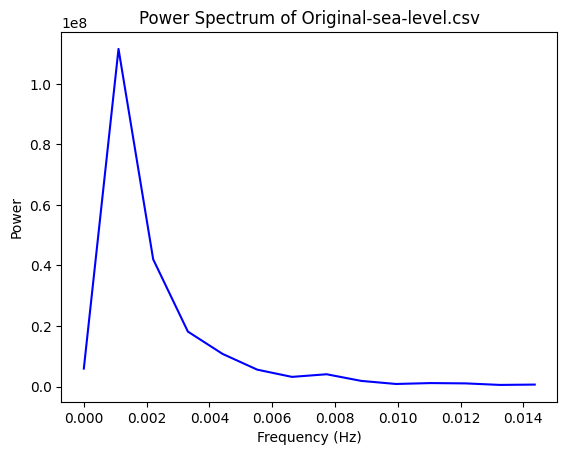

In [12]:
# Function to plot Amplitude Distribution
def plot_amplitude_distribution(data, title):
    plt.figure()
    plt.hist(data, bins=50, alpha=0.75, edgecolor='black')
    plt.title(f'Amplitude Distribution of {title}')
    plt.xlabel('Amplitude')
    plt.ylabel('Frequency')
    plt.show()

# Function to plot Power Spectrum
def plot_power_spectrum(data, sr, title):
    n = len(data)
    freqs = np.fft.fftfreq(n, 1/sr)
    fft_values = fft(data)
    power_spectrum = np.abs(fft_values)**2
    
    plt.figure()
    plt.plot(freqs[:n // 64], power_spectrum[:n // 64], color='blue')
    plt.title(f'Power Spectrum of {title}')
    plt.xlabel('Frequency (Hz)')
    plt.ylabel('Power')
    plt.show()

#Also plot the original data so we can see it better
plt.plot(originalData)
plt.title(f'Waveform of Original-{originalDataSetName}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Plot the amplitude distribution of the original data
plot_amplitude_distribution(originalData, f"Original-{originalDataSetName}")

# Plot the power spectrum of the original data
plot_power_spectrum(originalData, sr, f"Original-{originalDataSetName}")

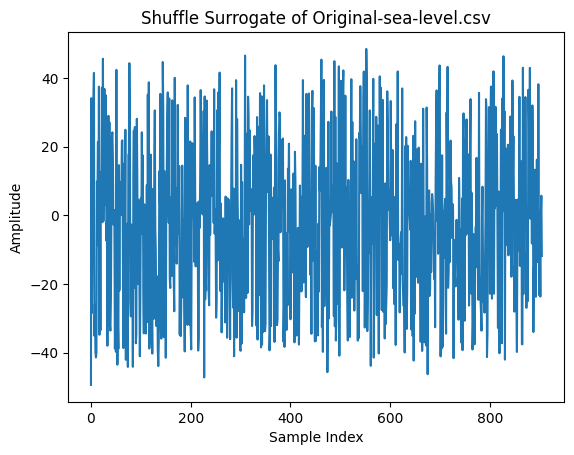

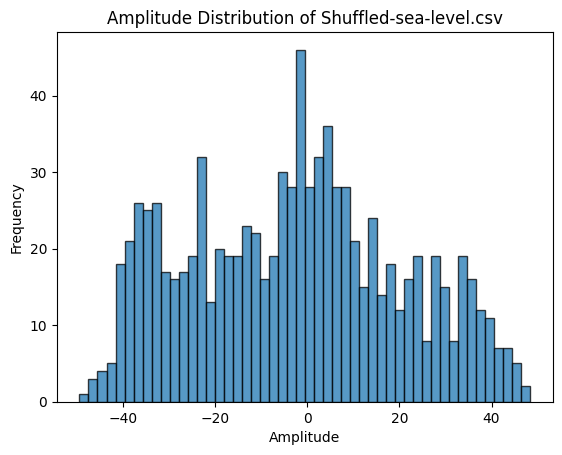

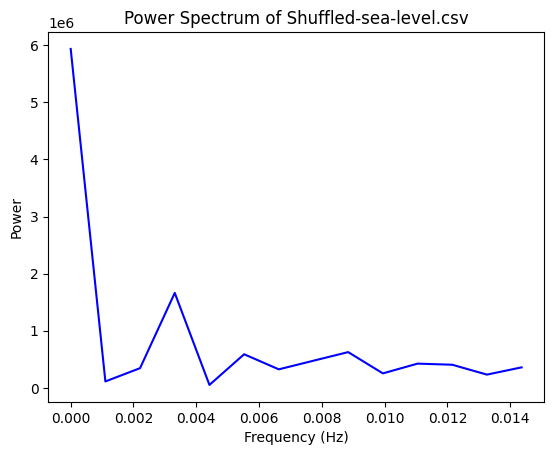

In [13]:
# Generate shuffle surrogate
shuffledData = np.copy(originalData)
np.random.shuffle(shuffledData)

plt.plot(shuffledData)
plt.title(f'Shuffle Surrogate of Original-{originalDataSetName}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Optionally, save the shuffled surrogate to a new .wav file
shuffled_filename = f"Shuffled-{originalDataSetName}"
wavfile.write(shuffled_filename, sr, shuffledData.astype(originalData.dtype))

# Plot the amplitude distribution of the original data
plot_amplitude_distribution(shuffledData, f"Shuffled-{originalDataSetName}")

# Plot the power spectrum of the original data
plot_power_spectrum(shuffledData, sr, f"Shuffled-{originalDataSetName}")

## Now let's move on to the Phase Randomized surrogates
Let's define a function for that!

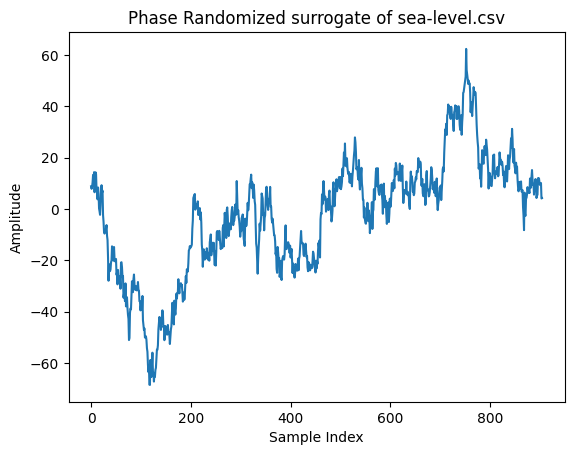

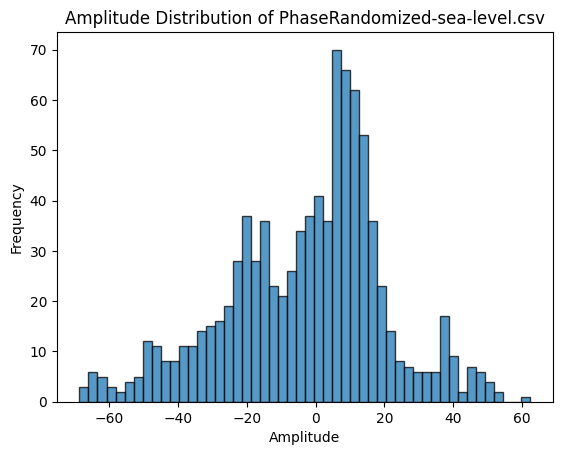

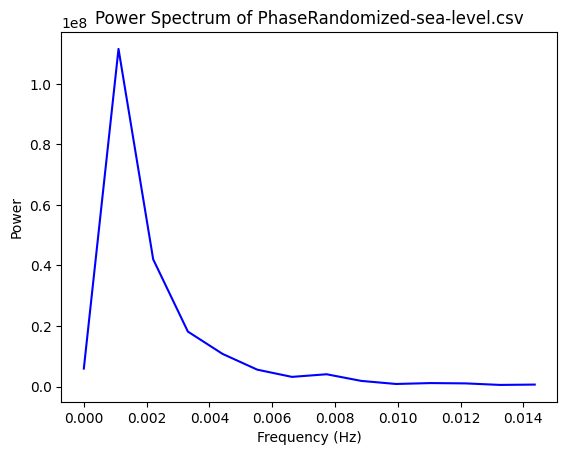

In [14]:
def phase_randomized_surrogate(data):
    n = len(data)
    
    # Step 1: Calculate the Fourier transform of the original signal
    fft_data = fft(data)
    
    # Step 2: Generate a vector of random phases
    random_phases = np.exp(2j * np.pi * np.random.rand(n // 2))
    
    # Step 3: Apply random phases to the positive frequencies
    fft_data[1:n//2+1] *= random_phases
    
    # Step 3 continued: Ensure the inverse symmetry by using the complex conjugate
    if n % 2 == 0:
        fft_data[n//2+1:] = np.conj(fft_data[1:n//2][::-1])
    else:
        fft_data[n//2+1:] = np.conj(fft_data[1:n//2+1][::-1])
    
    # Step 4: Inverse Fourier transform to get the surrogate
    surrogate_data = np.real(ifft(fft_data))
    
    return surrogate_data

# Generate phase randomized surrogate
phaseRandomizedData = np.copy(originalData)
phaseRandomizedData = phase_randomized_surrogate(phaseRandomizedData)

plt.plot(phaseRandomizedData)
plt.title(f'Phase Randomized surrogate of {originalDataSetName}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Optionally, save the phase randomized surrogate to a new .wav file
phase_randomized_filename = f"PhaseRandomized-{originalDataSetName}"
wavfile.write(phase_randomized_filename, sr, phaseRandomizedData.astype(originalData.dtype))

# Plot the amplitude distribution of the phase randomized data
plot_amplitude_distribution(phaseRandomizedData, f"PhaseRandomized-{originalDataSetName}")

# Plot the power spectrum of the phase randomized data
plot_power_spectrum(phaseRandomizedData, sr, f"PhaseRandomized-{originalDataSetName}")

Not the best result, but we can see it trying! Let's see if IAAFT does any better.

## Iterated Amplitude Adjusted Fourier Transform Surrogates

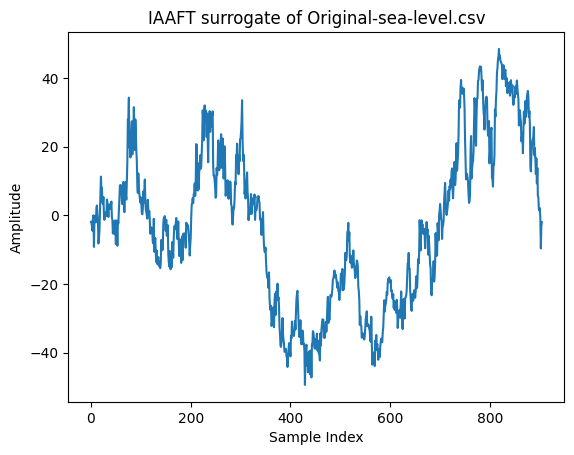

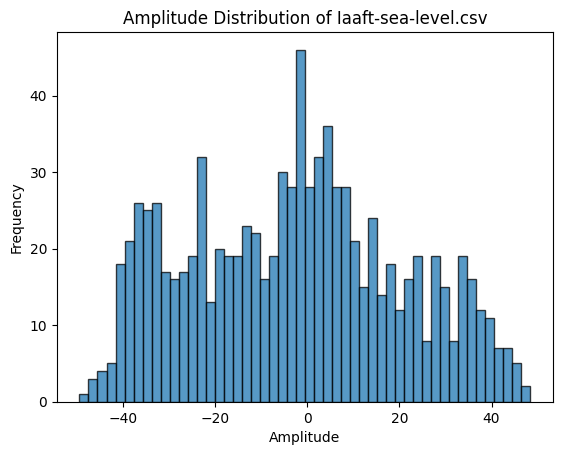

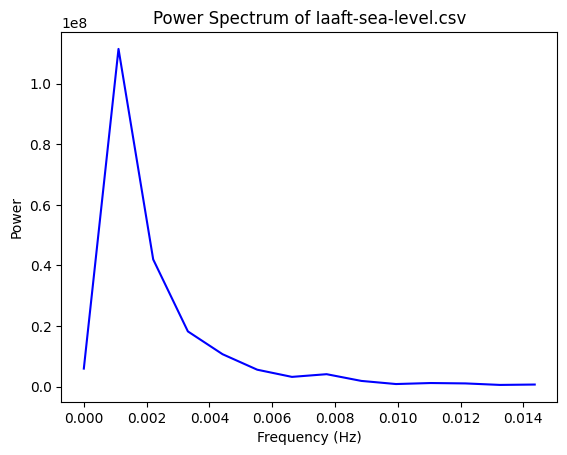

In [15]:
def iaaft_surrogate(data, max_iter=1000, tol=1e-8):
    n = len(data)
    
    # Step 1: Generate a random shuffle of the data
    surrogate = np.random.permutation(data)
    
    # Fourier transform of the original data
    original_fft = fft(data)
    original_amplitude = np.abs(original_fft)
    
    for i in range(max_iter):
        # Step 2: Fourier transform of the current iteration
        surrogate_fft = fft(surrogate)
        
        # Replace Fourier amplitudes with those from the original signal
        surrogate_fft = original_amplitude * np.exp(1j * np.angle(surrogate_fft))
        
        # Inverse Fourier transform to get z(i)n
        z = np.real(ifft(surrogate_fft))
        
        # Step 3: Rescale z to the original distribution of the data
        sorted_surrogate = np.sort(surrogate)
        ranks = np.argsort(np.argsort(z))
        surrogate_new = sorted_surrogate[ranks]
        
        # Check for convergence
        if np.allclose(surrogate, surrogate_new, atol=tol):
            break
        
        surrogate = surrogate_new
    
    return surrogate

# Generate IAAFT surrogate
iaaftData = np.copy(originalData)
iaaftData = iaaft_surrogate(iaaftData)

plt.plot(iaaftData)
plt.title(f'IAAFT surrogate of Original-{originalDataSetName}')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.show()

# Optionally, save the IAAFT surrogate to a new .wav file
iaaftData_filename = f"IaaftData-{originalDataSetName}"
wavfile.write(iaaftData_filename, sr, iaaftData.astype(originalData.dtype))

# Plot the amplitude distribution of the IAAFT data
plot_amplitude_distribution(iaaftData, f"Iaaft-{originalDataSetName}")

# Plot the power spectrum of the IAAFT data
plot_power_spectrum(iaaftData, sr, f"Iaaft-{originalDataSetName}")

## For the case of the sea level data set, let's create a null hypothesis
As our hypothesis is that sea levels rise, we need to compare our source data with a dataset of the null hypothesis.

The null hypothesis in this case is that all sea level variations come from data aquisition or instrument errors.

Thus, we want to check the original data against a null hypothesis.

To do this, we will generate a large amount of surrogate datasets with the random shuffle method.


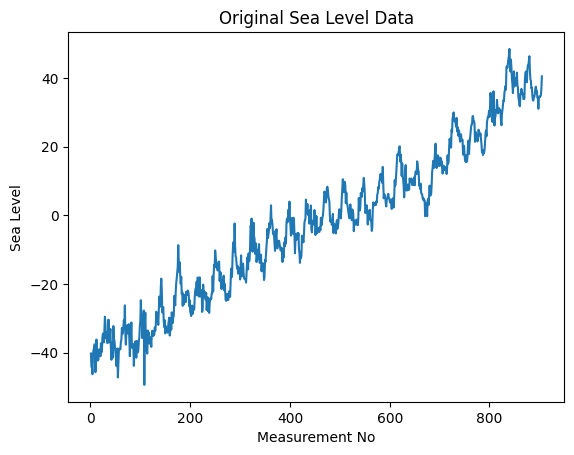

In [16]:
# Plot the original data
plt.plot(df['measurement_no'], originalData)
plt.title('Original Sea Level Data')
plt.xlabel('Measurement No')
plt.ylabel('Sea Level')
plt.show()

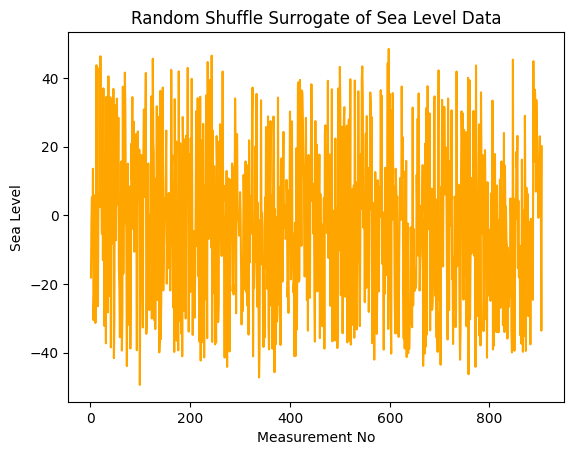

In [17]:
def random_shuffle_surrogate(data):
    surrogate = np.random.permutation(data)
    return surrogate

# Generate a random shuffle surrogate
randomSurrogateData = random_shuffle_surrogate(np.copy(originalData))

# Plot the random shuffle surrogate
plt.plot(df['measurement_no'], randomSurrogateData, color='orange')
plt.title('Random Shuffle Surrogate of Sea Level Data')
plt.xlabel('Measurement No')
plt.ylabel('Sea Level')
plt.show()

## Let's now calculate the Original data slope, and the slope for a random shuffle surrogate

In [18]:
# Calculate the trend in the original data
original_slope, original_intercept, r_value, p_value, std_err = linregress(df['measurement_no'], originalData)

# Function to calculate the trend (slope) in the data
def calculate_trend(data):
    slope, intercept, r_value, p_value, std_err = linregress(df['measurement_no'], data)
    return slope

# Calculate the trend in the random shuffle surrogate
randomSurrogateSlope = calculate_trend(randomSurrogateData)

print(f"Original Data Slope: {original_slope}")
print(f"Random Surrogate Data Slope: {randomSurrogateSlope}")

Original Data Slope: 0.08608693425048478
Random Surrogate Data Slope: -0.005929137000579264


## Now, generate a large number of randonm shuffle surrogates which are all representative to the null hypothesis
For each surrogate we can then calculate the slope like above, and generate a distribution of slopes for the null hypothesis

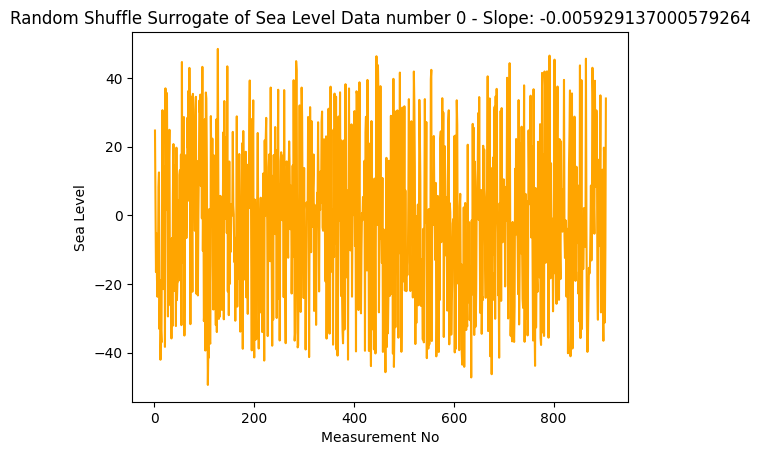

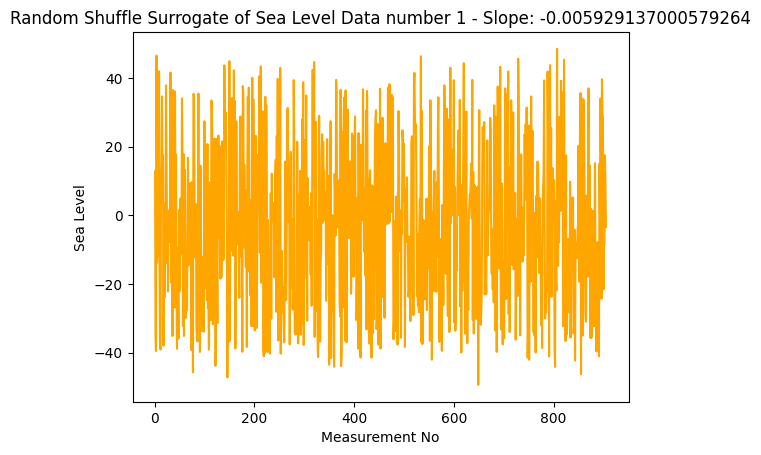

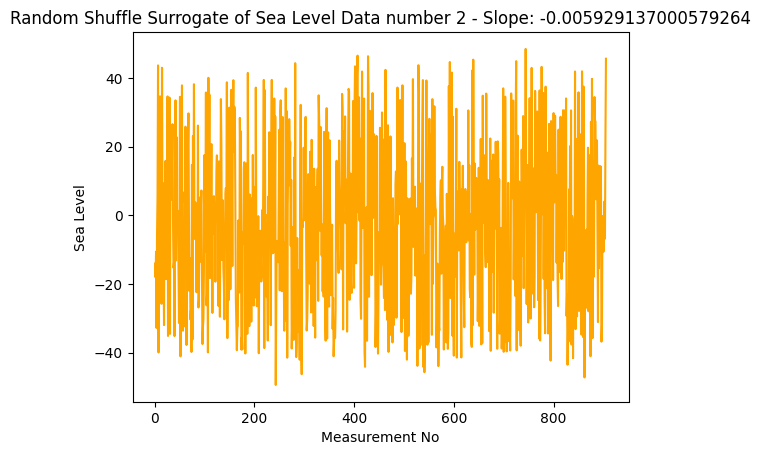

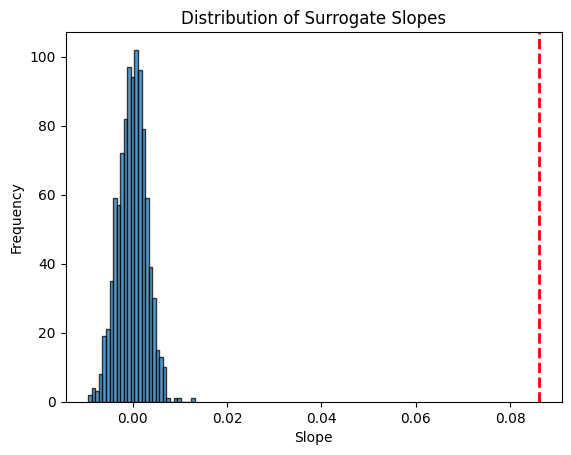

P-value: 0.0
The trend in the original data is statistically significant.


In [19]:
# Generate multiple surrogates to build a distribution of surrogate slopes
num_surrogates = 1000
surrogate_slopes = []

for i in range(num_surrogates):
    surrogate = random_shuffle_surrogate(np.copy(originalData))
    if i < 3:
        # Plot the random shuffle surrogate
        randomSurrogateSlope = calculate_trend(randomSurrogateData)
        plt.plot(df['measurement_no'], surrogate, color='orange')
        plt.title(f'Random Shuffle Surrogate of Sea Level Data number {i} - Slope: {randomSurrogateSlope}')
        plt.xlabel('Measurement No')
        plt.ylabel('Sea Level')
        plt.show()
    slope = calculate_trend(surrogate)
    surrogate_slopes.append(slope)

# Convert to numpy array for easy handling
surrogate_slopes = np.array(surrogate_slopes)

# Plot the distribution of surrogate slopes
plt.hist(surrogate_slopes, bins=30, alpha=0.75, edgecolor='black')
plt.axvline(original_slope, color='red', linestyle='dashed', linewidth=2)
plt.title('Distribution of Surrogate Slopes')
plt.xlabel('Slope')
plt.ylabel('Frequency')
plt.show()

# Calculate p-value
p_value = np.sum(surrogate_slopes >= original_slope) / num_surrogates
print(f"P-value: {p_value}")

# Interpret the result
if p_value < 0.05:
    print("The trend in the original data is statistically significant.")
else:
    print("The trend in the original data is not statistically significant.")

## Conclusion
As can be intuitively deduced from the distribution graph, and as can be seen from the P-value calculation, we have confirmed that our model's prediction is statistically relevant, so our data model is valid.